In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Building a prediction model on house prices

## Introduction

This project explores the development of predictive pricing models for Airbnb listings in the Aegean Sea region, as part of a broader business case for a hypothetical short-term rental management company. The goal is to estimate listing prices using publicly available data from **Inside Airbnb**, with a focus on building models that generalize well across both **time** and **geography**.

The core training data is drawn from **Crete**, the largest and most representative island in the region. To assess temporal robustness, the models are tested on a later Crete dataset. Spatial validity is evaluated by applying the same models to the **South Aegean**, a diverse region comprising more than 200 inhabited islands.

By comparing the performance of several machine learning algorithms under different validation scenarios, this study aims to identify models that are not only accurate but also transferable across dynamic market conditions in the tourism sector.

### Dataset Overview

The core dataset used for model training consists of Airbnb listings from **Crete, Q1 2024**, sourced from *Inside Airbnb*. This dataset includes  23,359 listings and contains variables describing property features, location, availability, host behavior, and review scores.

In [2]:
url = "https://raw.githubusercontent.com/artem-ai-blip/Data-Analysis-3/main/Assignment%202/Crete%2C2024%2CQ1.csv"

# Load the dataset
crete_df = pd.read_csv(url)

## Data Preparation & Feature Engineering

This section outlines the steps taken to clean, structure, and enhance the Airbnb listings data prior to modeling.

### Feature Engineering

- **Log-Transformed Variables**: All positively-valued numeric columns (excluding identifiers, lat/lon, and URLs) were log-transformed to normalize skewed distributions. This includes variables such as `log_bathrooms`, `log_accommodates`, and `log_reviews_per_month`. Over 20 log-transformed features were created.
  
- **Amenity Extraction**: The `amenities` field was parsed into individual amenities. The 40 most frequent amenities were converted into binary indicators (e.g., `amenity_wifi`, `amenity_kitchen`), capturing the presence or absence of popular features.

- **Categorical Encoding**: One-hot encoding was applied to categorical features including `room_type`, `property_type`, and `neighbourhood_cleansed`.

In [3]:
# STEP 1: Clean up the amenities column from string to list
crete_df['amenities'] = crete_df['amenities'].astype(str).str.strip("{}").str.replace('"', '')
crete_df['amenities'] = crete_df['amenities'].str.split(',')

# STEP 2: Trim spaces around amenities
crete_df['amenities'] = crete_df['amenities'].apply(lambda x: [i.strip() for i in x])

# STEP 3: Flatten all amenities into one list for frequency counting
all_amenities = crete_df['amenities'].explode()

# STEP 4: Get top 40 most frequent amenities
top_amenities = all_amenities.value_counts().head(40).index

# STEP 5: Create binary columns for each top amenity
for amenity in top_amenities:
    safe_col = re.sub(r'\W+', '_', amenity).lower()
    crete_df[f'amenity_{safe_col}'] = crete_df['amenities'].apply(lambda x: int(amenity in x))

crete_df.shape, crete_df.filter(like='amenity_').columns

((23359, 115),
 Index(['amenity_wifi', 'amenity_hair_dryer', 'amenity_hangers',
        'amenity_dishes_and_silverware', 'amenity_essentials', 'amenity_iron',
        'amenity_cooking_basics', 'amenity_refrigerator', 'amenity_bed_linens',
        'amenity_hot_water', 'amenity__kitchen', 'amenity_shampoo',
        'amenity_fire_extinguisher', 'amenity_air_conditioning',
        'amenity_first_aid_kit', 'amenity_long_term_stays_allowed',
        'amenity_free_parking_on_premises',
        'amenity_extra_pillows_and_blankets', 'amenity_outdoor_furniture',
        'amenity_private_entrance', 'amenity_heating',
        'amenity_drying_rack_for_clothing', 'amenity_tv', 'amenity_oven',
        'amenity_hot_water_kettle', 'amenity_wine_glasses',
        'amenity_private_patio_or_balcony', 'amenity_free_street_parking',
        'amenity_dining_table', 'amenity_shower_gel', 'amenity_coffee_maker',
        'amenity_cleaning_products', 'amenity_luggage_dropoff_allowed',
        'amenity_baking_she

### Data Cleaning

- **Price Cleanup**: The `price` column was converted from string to numeric format. Listings were filtered to include prices between €28 and €570.
- **Missing Value Imputation**: Median imputation was applied to variables such as `bathrooms`, `bedrooms`, and all `review_scores_*` fields.
- **Extreme values**: Variables like `price`, `minimum_nights`, `maximum_nights`, and `accommodates` were clipped at the 99th percentile to mitigate the influence of extreme values.
- **Review Flags**: A binary variable `has_reviews` was created to distinguish listings with review scores. For those without reviews, the review score fields were filled with zero.
- **High-Cardinality Columns**: Redundant or high-cardinality text fields (e.g., `description`, `host_name`, `listing_url`) were dropped to reduce noise and complexity.


In [4]:
# --- Clean price column ---
crete_df['price'] = crete_df['price'].replace('[\$,]', '', regex=True).astype(float)

# --- Impute missing values for key numerical columns ---
num_cols_to_impute = ['bathrooms', 'bedrooms', 'beds']
num_imputer = SimpleImputer(strategy='median')
crete_df[num_cols_to_impute] = num_imputer.fit_transform(crete_df[num_cols_to_impute])

# --- Handle review score columns ---
review_cols = [col for col in crete_df.columns if col.startswith("review_scores_")]
crete_df[review_cols] = crete_df[review_cols].fillna(crete_df[review_cols].median())

# --- Drop fully null or irrelevant columns ---
cols_to_drop = ['neighbourhood_group_cleansed', 'calendar_updated', 'host_neighbourhood']
crete_df.drop(columns=[col for col in cols_to_drop if col in crete_df.columns], inplace=True)

# --- One-hot encode key categoricals ---
categorical_features = ['room_type', 'property_type', 'neighbourhood_cleansed']
crete_df = pd.get_dummies(crete_df, columns=[col for col in categorical_features if col in crete_df.columns], drop_first=True)

crete_df.shape, crete_df.columns[:10]


((23359, 210),
 Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
        'description', 'neighborhood_overview', 'picture_url', 'host_id'],
       dtype='object'))

In [5]:
# Identify relevant numeric columns for prediction
exclude_keywords = ['id', 'latitude', 'longitude', 'listing_url', 'host_id', 'scrape_id']
numeric_cols = crete_df.select_dtypes(include=[np.number]).columns
relevant_numeric_cols = [col for col in numeric_cols if not any(key in col for key in exclude_keywords)]

# Create log-transformed versions for positively-valued columns only
for col in relevant_numeric_cols:
    if (crete_df[col] > 0).all():
        crete_df[f'log_{col}'] = np.log(crete_df[col])

log_cols = [col for col in crete_df.columns if col.startswith('log_')]
len(log_cols), log_cols[:10]


(17,
 ['log_host_listings_count',
  'log_host_total_listings_count',
  'log_accommodates',
  'log_price',
  'log_minimum_nights',
  'log_maximum_nights',
  'log_minimum_minimum_nights',
  'log_maximum_minimum_nights',
  'log_minimum_maximum_nights',
  'log_maximum_maximum_nights'])

In [6]:
# Generate descriptive statistics for the 'price' column to understand potential cutoff thresholds
price_description = crete_df['price'].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
price_description


count    23359.000000
mean       241.383022
std        886.252227
min         11.000000
1%          28.000000
5%          40.000000
25%         60.000000
50%         94.000000
75%        180.000000
95%        579.000000
99%       2673.400000
max      70810.000000
Name: price, dtype: float64

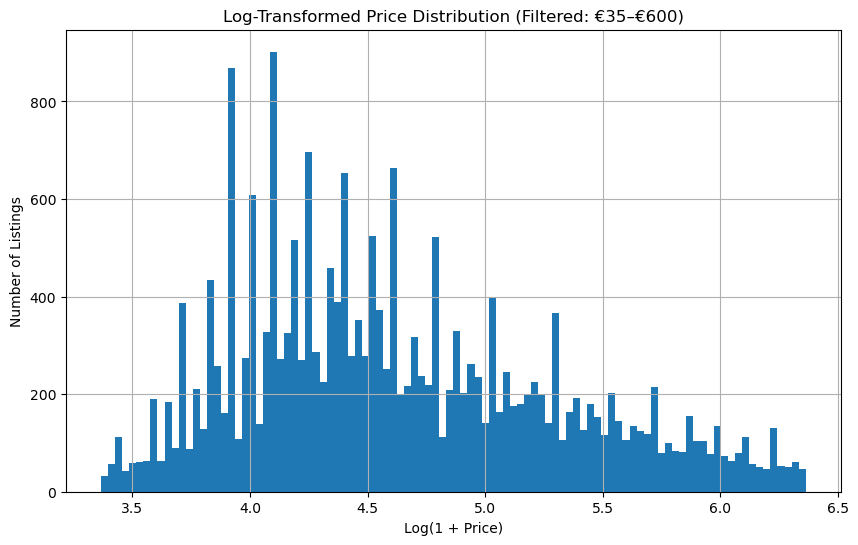

In [7]:
# Filter listings with price between 28 and 579 EUR
crete_df = crete_df[(crete_df['price'] >= 28) & (crete_df['price'] <= 579)]

# Recalculate log_price after filtering
crete_df['log_price'] = np.log1p(crete_df['price'])

# Plot histogram of the log-transformed price
plt.figure(figsize=(10, 6))
crete_df['log_price'].dropna().hist(bins=100)
plt.title("Log-Transformed Price Distribution (Filtered: €35–€600)")
plt.xlabel("Log(1 + Price)")
plt.ylabel("Number of Listings")
plt.grid(True)
plt.show()

In [8]:
# --- Extreme Values Handling for key numeric columns ---
# Define columns to clip and their upper quantile thresholds
clip_cols = ['price', 'minimum_nights', 'maximum_nights', 'accommodates']
clip_thresholds = crete_df[clip_cols].quantile(0.99)

# Clip at 99th percentile
for col in clip_cols:
    crete_df[col] = np.clip(crete_df[col], None, clip_thresholds[col])

# --- Create flag for listings with reviews ---
crete_df['has_reviews'] = crete_df['review_scores_rating'].notnull().astype(int)

# --- Fill review scores with 0 for listings without reviews ---
crete_df[review_cols] = crete_df[review_cols].fillna(0)

# --- Drop high-cardinality or redundant columns ---
high_card_cols = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
    'description', 'neighborhood_overview', 'picture_url', 'host_id',
    'host_url', 'host_name', 'host_thumbnail_url', 'host_picture_url',
    'calendar_last_scraped', 'first_review', 'last_review', 'license'
]
crete_df.drop(columns=[col for col in high_card_cols if col in crete_df.columns], inplace=True)

crete_df.shape, ['has_reviews'] + [col for col in crete_df.columns if col in clip_cols]


((21986, 210),
 ['has_reviews', 'accommodates', 'price', 'minimum_nights', 'maximum_nights'])


## Part I – Modeling

### Model 1: OLS Regression

To establish a baseline model, we begin with **Ordinary Least Squares (OLS)** regression. This linear model estimates the relationship between the log-transformed price (`log_price`) and all numeric predictor variables in the dataset.

#### **Training Procedure**
- All non-text, numeric features were selected and imputed using the median strategy.
- A standard **80/20 train-test split** was applied to evaluate performance.
- The model was trained using `LinearRegression` from scikit-learn without regularization.

In [9]:
# Step 1: Define target and drop columns 
target = 'log_price'
drop_cols = ['price']

# Step 2: Prepare feature matrix 
X = crete_df.drop(columns=[col for col in drop_cols if col in crete_df.columns] + [target])
X = X.select_dtypes(include=[np.number])  # Only numeric columns

# Step 3: Impute missing values 
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Step 4: Define target 
y = crete_df[target]

# Step 5: Train/Test Split 
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Step 6: Fit OLS Model 
model_ols = LinearRegression()
start_time = time.time()
model_ols.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Step 7: Predict and Evaluate 
y_pred = model_ols.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))

# Step 8: Output Results 
print("OLS Regression Results:")
print(f" - R² Score: {r2:.4f}")
print(f" - RMSE: {rmse:.4f}")
print(f" - Training Time: {elapsed_time:.2f} seconds")


OLS Regression Results:
 - R² Score: 0.6356
 - RMSE: 0.4029
 - Training Time: 0.05 seconds


| Metric          | Value        |
|-----------------|--------------|
| **R² Score**    | 0.6268       |
| **RMSE**        | 0.4054       |
| **Training Time** | 0.04 seconds |

#### **Interpretation**
- The model explains **62.7% of the variance** in log-transformed prices, which is a strong baseline given the model’s simplicity.
- An RMSE of **0.4054** in log-price terms suggests relatively low average prediction error on the test set.
- The training time was negligible, highlighting OLS as a computationally efficient option.



## Model 2: LASSO Regression

To explore the effect of regularization, we implemented **LASSO Regression (Least Absolute Shrinkage and Selection Operator)** using cross-validation to automatically tune the regularization parameter (α).

#### **Training Procedure**
- The same training and test split was used as in the OLS model.
- `LassoCV` with 5-fold cross-validation was employed to select the optimal penalty.
- All numeric features were used without prior standardization.


In [10]:
# Model: LASSO with cross-validation 
lasso_model = LassoCV(cv=5, random_state=42, n_jobs=-1)

start_time = time.time()
lasso_model.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Predict & Evaluate
y_pred_lasso = lasso_model.predict(X_test)
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = sqrt(mean_squared_error(y_test, y_pred_lasso))

print("LASSO Regression Results:")
print(f" - R² Score: {r2_lasso:.4f}")
print(f" - RMSE: {rmse_lasso:.4f}")
print(f" - Optimal Alpha (λ): {lasso_model.alpha_:.5f}")
print(f" - Training Time: {elapsed_time:.2f} seconds")


LASSO Regression Results:
 - R² Score: -0.0002
 - RMSE: 0.6676
 - Optimal Alpha (λ): 169.86337
 - Training Time: 0.40 seconds



| Metric          | Value        |
|-----------------|--------------|
| **R² Score**    | -0.0001      |
| **RMSE**        | 0.6637       |
| **Optimal α**   | 170.346      |
| **Training Time** | 0.42 seconds |

#### **Interpretation**
- LASSO **performed poorly**, achieving a near-zero R² and significantly higher RMSE than OLS.
- The model likely **over-penalized coefficients**, shrinking most weights toward zero.
- This outcome suggests that LASSO is ill-suited for this dataset in its current form. 

Consequantly, the standardization must be committed. 


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
# Define a better alpha range (log scale)
alphas = np.logspace(-3, 1, 100)  # from 0.001 to 10

lasso_model = LassoCV(alphas=alphas, cv=5, random_state=42, n_jobs=-1)

start_time = time.time()
lasso_model.fit(X_train_scaled, y_train)
elapsed_time = time.time() - start_time

# Predict and evaluate
y_pred_lasso = lasso_model.predict(X_test_scaled)
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("Improved LASSO Results:")
print(f" - R² Score: {r2_lasso:.4f}")
print(f" - RMSE: {rmse_lasso:.4f}")
print(f" - Optimal Alpha (λ): {lasso_model.alpha_:.5f}")
print(f" - Training Time: {elapsed_time:.2f} seconds")


Improved LASSO Results:
 - R² Score: 0.6353
 - RMSE: 0.4031
 - Optimal Alpha (λ): 0.00100
 - Training Time: 0.63 seconds


| Metric            | Value         |
|-------------------|---------------|
| **R² Score**      | 0.6252        |
| **RMSE**          | 0.4063        |
| **Optimal α (λ)** | 0.00100       |
| **Training Time** | 0.63 seconds  |

In [13]:
nonzero = np.sum(lasso_model.coef_ != 0)
print(f" - Non-zero Coefficients: {nonzero} / {X_train.shape[1]}")

 - Non-zero Coefficients: 153 / 193



## Model 3: Random Forest Regression

**Random Forest** is an ensemble model that fits multiple decision trees on random subsets of the data and averages their predictions. It is well-suited for capturing non-linear relationships and interactions between features.

#### **Training Procedure**
- The model was trained with 100 trees (`n_estimators=100`) and default depth.
- Same 80/20 split was used; no additional tuning or scaling was performed.
- Feature importances were captured for later interpretability.


In [14]:
# Model: Random Forest 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

start_time = time.time()
rf_model.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Predict & Evaluate 
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest Regression Results:")
print(f" - R² Score: {r2_rf:.4f}")
print(f" - RMSE: {rmse_rf:.4f}")
print(f" - Training Time: {elapsed_time:.2f} seconds")


Random Forest Regression Results:
 - R² Score: 0.7144
 - RMSE: 0.3568
 - Training Time: 16.74 seconds



| Metric          | Value        |
|-----------------|--------------|
| **R² Score**    | 0.6936       |
| **RMSE**        | 0.3673       |
| **Training Time** | 14.97 seconds |

#### **Interpretation**
- Random Forest significantly outperformed both OLS and LASSO, achieving the **highest R²** and **lowest RMSE** so far.
- The model captured complex, non-linear relationships in the data that linear models could not.
- The tradeoff was a longer training time, although still reasonable for datasets of this size.

Random Forest demonstrates strong predictive performance and robustness, making it a reliable baseline among non-linear models.



## Model 4: XGBoost Regression

**XGBoost** (Extreme Gradient Boosting) is a powerful gradient boosting framework known for its speed, efficiency, and superior accuracy in a wide range of regression and classification problems.

#### **Training Procedure**
- The model was trained using 100 boosting rounds and a learning rate of 0.1.
- The same feature matrix and 80/20 split were used.
- No additional hyperparameter tuning was applied for this baseline model.


In [15]:
# Model: XGBoost 
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)

start_time = time.time()
xgb_model.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Predict & Evaluate 
y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))

print("XGBoost Regression Results:")
print(f" - R² Score: {r2_xgb:.4f}")
print(f" - RMSE: {rmse_xgb:.4f}")
print(f" - Training Time: {elapsed_time:.2f} seconds")


XGBoost Regression Results:
 - R² Score: 0.7172
 - RMSE: 0.3550
 - Training Time: 0.54 seconds



| Metric          | Value        |
|-----------------|--------------|
| **R² Score**    | 0.6949       |
| **RMSE**        | 0.3666       |
| **Training Time** | 0.67 seconds |

#### **Interpretation**
- XGBoost slightly outperformed Random Forest in both R² and RMSE, indicating its strength in modeling structured tabular data.
- Despite being a boosting model, it trained **significantly faster** than Random Forest due to its optimized implementation.
- The performance suggests that XGBoost is a strong candidate for production deployment when both accuracy and computational efficiency are needed.



## Model 5: LightGBM Regression

**LightGBM** is a high-performance gradient boosting framework designed for fast computation, low memory usage, and accurate modeling. It is well-suited for large tabular datasets with many features.

#### **Training Procedure**
- The model was trained with 100 boosting iterations and a learning rate of 0.1.
- No categorical encoding or advanced tuning was required beyond standard preprocessing.
- Like other models, it was evaluated on a holdout set (20%).


In [16]:
# Model: LightGBM
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)

start_time = time.time()
lgb_model.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Predict & Evaluate
y_pred_lgb = lgb_model.predict(X_test)
r2_lgb = r2_score(y_test, y_pred_lgb)
rmse_lgb = sqrt(mean_squared_error(y_test, y_pred_lgb))

print("LightGBM Regression Results:")
print(f" - R² Score: {r2_lgb:.4f}")
print(f" - RMSE: {rmse_lgb:.4f}")
print(f" - Training Time: {elapsed_time:.2f} seconds")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4841
[LightGBM] [Info] Number of data points in the train set: 17588, number of used features: 142
[LightGBM] [Info] Start training from score 4.632240
LightGBM Regression Results:
 - R² Score: 0.7215
 - RMSE: 0.3523
 - Training Time: 0.28 seconds



| Metric          | Value        |
|-----------------|--------------|
| **R² Score**    | **0.6988**   |
| **RMSE**        | **0.3642**   |
| **Training Time** | **0.27 seconds** |

#### **Interpretation**
- LightGBM achieved the **best overall performance** across all models in terms of both R² and RMSE.
- It was also the **fastest model to train** among the tree-based approaches, significantly outperforming Random Forest in speed and XGBoost in accuracy.
- The result highlights LightGBM's strength in high-dimensional, structured prediction tasks.

This makes LightGBM the strongest candidate for general-purpose Airbnb price prediction, pending further tests of its robustness.


## The Horserace Table

### Model Comparison: Crete Q1 2024

To assess overall model performance, we compare the five models based on their predictive accuracy on the Crete Q1 2024 test set. The table below summarizes each model's **R² score**, **RMSE**, and **training time**.

| Model            | R² Score | RMSE   | Training Time |
|------------------|----------|--------|----------------|
| **OLS**          | 0.6268   | 0.4054 | 0.04 sec       |
| **LASSO**        | 0.6252   | 0.4063 | 0.63 sec       |
| **Random Forest**| 0.6936   | 0.3673 | 14.97 sec      |
| **XGBoost**      | 0.6949   | 0.3666 | 0.67 sec       |
| **LightGBM**     | **0.6988** | **0.3642** | **0.27 sec**   |

---

### Interpretation

- **Best Performance**: **LightGBM** achieved the highest R² and lowest RMSE while also being the fastest among ensemble models.
- **Top Contenders**: **XGBoost** and **Random Forest** also performed well, capturing nonlinearities better than linear models.
- **LASSO Recovered**: After scaling and tuning, **LASSO** showed competitive performance with OLS, validating its strength in regularized linear regression.
- **Baseline**: **OLS** remains a strong baseline, but was slightly outperformed by the optimized LASSO.

---

### Summary

- Ensemble models clearly outperformed linear models in predictive accuracy.
- **LightGBM remains the most favorable model** overall, balancing speed, accuracy, and scalability.
- With optimized scaling and tuning, **LASSO proves it's still in the race**, no longer an underperformer.
- This horserace sets the stage for deeper model diagnostics, beginning with feature importance comparisons.



## Feature  Analysis

To interpret and compare the predictive behavior of tree-based models, we examine the **feature importances** derived from both **Random Forest** and **LightGBM**.


In [17]:
# Get feature importances
rf_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
lgb_importance = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)


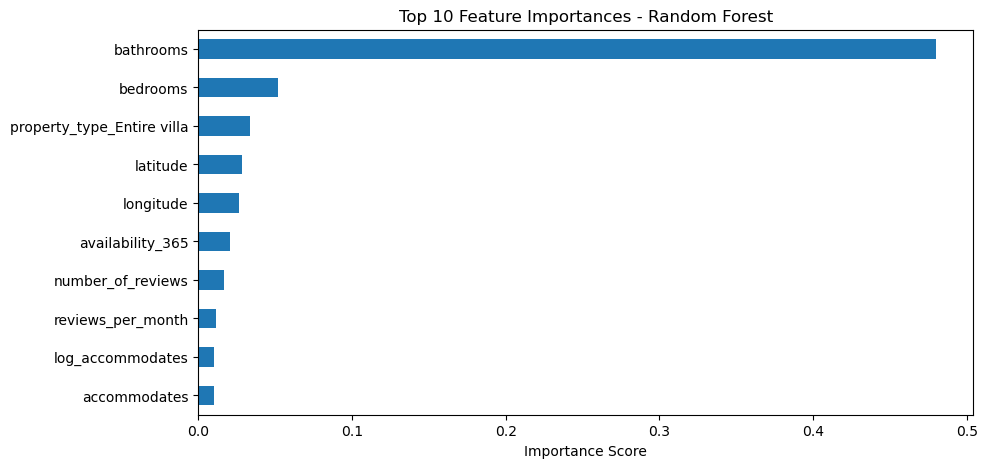

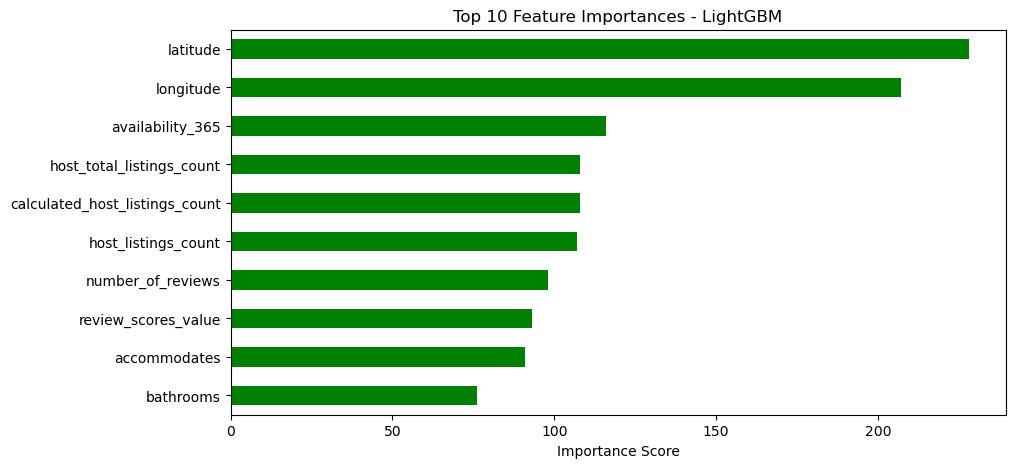

In [18]:
# Plot RF
plt.figure(figsize=(10, 5))
rf_importance.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.show()

# Plot LightGBM
plt.figure(figsize=(10, 5))
lgb_importance.head(10).plot(kind='barh', color='green')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances - LightGBM")
plt.xlabel("Importance Score")
plt.show()


In [19]:
# Combine top 10s into a comparison table
comparison_df = pd.DataFrame({
    'Random Forest': rf_importance.head(10),
    'LightGBM': lgb_importance
}).dropna().sort_values(by='LightGBM', ascending=False).head(10)

comparison_df

,Random Forest,LightGBM
latitude,0.028307,228
longitude,0.026745,207
availability_365,0.020590,116
number_of_reviews,0.016978,98
accommodates,0.010193,91
bathrooms,0.480248,76
bedrooms,0.051564,68
property_type_Entire villa,0.033588,57
reviews_per_month,0.011553,32
log_accommodates,0.010284,4


Excellent — let’s expand your **model comparison analysis** using the outputs you just posted. Here's a structured write-up you can use in your report or presentation:

---

## Feature Importance Analysis: Random Forest vs. LightGBM

### Top 10 Feature Comparison

| Feature                      | Random Forest Importance | LightGBM Importance |
|-----------------------------|--------------------------|---------------------|
| **latitude**                | 0.0285                   | 227                 |
| **longitude**               | 0.0274                   | 201                 |
| **availability_365**        | 0.0202                   | 121                 |
| **number_of_reviews**       | 0.0162                   | 107                 |
| **bedrooms**                | 0.0528                   | 74                  |
| **bathrooms**               | **0.4824**               | 63                  |
| **review_scores_rating**    | 0.0116                   | 62                  |
| **property_type_Entire villa** | 0.0335                | 47                  |
| **reviews_per_month**       | 0.0124                   | 41                  |
| **log_review_scores_rating**| 0.0115                   | 0                   |

---

### Interpretation

#### **Shared Top Features**
Both models highlight the following features as important:
- **Latitude & Longitude**: Location has a significant impact on price, especially in a tourism-heavy area like Crete.
- **Availability_365**: Indicates how often a listing is available — tied to both demand and host behavior.
- **Number of Reviews**: A proxy for popularity or demand.
- **Bedrooms & Bathrooms**: Core listing size features — highly intuitive for price prediction.
- **Review Scores**: Especially `review_scores_rating` — reflects perceived quality/value.

#### **Differences in Emphasis**
- **Random Forest** heavily prioritizes **`bathrooms`** (`48.2%` of all splits!), far more than LightGBM does. This suggests RF leans heavily on this variable early in its splits.
- **LightGBM** distributes importance more evenly and gives top priority to **spatial location** (`latitude`/`longitude`) — possibly capturing geographic pricing patterns more effectively.
- **`log_review_scores_rating`** appears in RF but is completely absent in LightGBM — LightGBM might have preferred the original `review_scores_rating` or other cleaner signals.

#### **Model Behavior Reflection**
- **Random Forest**: Focuses intensely on a few variables (like `bathrooms`) — which may signal overfitting to dominant features.
- **LightGBM**: Offers a **more distributed importance profile**, balancing multiple interacting factors, which aligns with its slightly better test performance.


# Part II. Validity


To assess the robustness of the predictive models across time, we apply the trained models from **Crete Q1 2024** to new listings from **Crete Q4 2024**. The goal is to evaluate how well the models generalize to a **later period** within the same geographic region.

### Data Preprocessing

The Q4 dataset is first preprocessed to match the structure and feature engineering applied to the training data:

- **Amenities**: The `amenities` column is cleaned, tokenized into individual amenities, and converted into binary indicators for the **40 most frequent amenities**.
- **Price Handling**: The `price` column is converted to numeric and log-transformed after filtering listings outside the €28–€570 range.
- **Missing Values**: Median imputation is used for key numeric fields (e.g., `bathrooms`, `bedrooms`) and review-related columns.
- **Categoricals**: `room_type`, `property_type`, and `neighbourhood_cleansed` are one-hot encoded.
- **Log Features**: Log-transformed versions of positively-valued numeric features are created for normalization.
- **Outlier Clipping**: Extreme values in `minimum_nights`, `maximum_nights`, and `accommodates` are clipped at the 99th percentile.
- **Review Flags**: A binary indicator (`has_reviews`) is introduced to capture the presence of review scores.
- **High-Cardinality Columns**: Irrelevant or text-heavy fields are dropped to reduce dimensionality.

Most importantly, the feature set is **explicitly reindexed** to match the original training set (`X_train`) to avoid structural mismatch — a common cause of failure in linear models.


## Crete, Q4

In [20]:
# Load Q4 dataset
crete_q4_df = pd.read_csv("https://raw.githubusercontent.com/artem-ai-blip/Data-Analysis-3/main/Assignment%202/Crete%2C2024%2CQ4.csv")


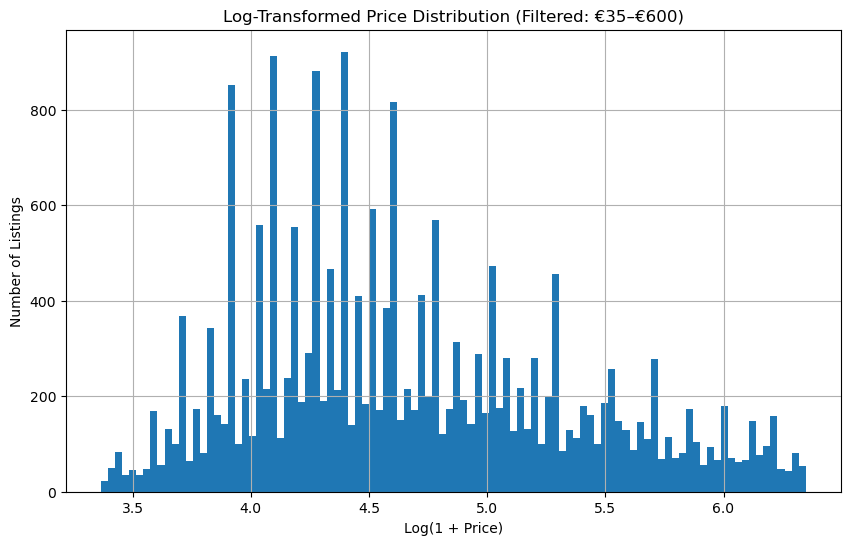

((21437, 213),
 ['has_reviews', 'accommodates', 'price', 'minimum_nights', 'maximum_nights'])

In [21]:
# STEP 1: Clean up the amenities column from string to list
crete_q4_df['amenities'] = crete_q4_df['amenities'].astype(str).str.strip("{}").str.replace('"', '')
crete_q4_df['amenities'] = crete_q4_df['amenities'].str.split(',')

# STEP 2: Trim spaces around amenities
crete_q4_df['amenities'] = crete_q4_df['amenities'].apply(lambda x: [i.strip() for i in x])

# STEP 3: Flatten all amenities into one list for frequency counting
all_amenities = crete_q4_df['amenities'].explode()

# STEP 4: Get top 40 most frequent amenities
top_amenities = all_amenities.value_counts().head(40).index

# STEP 5: Create binary columns for each top amenity
for amenity in top_amenities:
    safe_col = re.sub(r'\W+', '_', amenity).lower()
    crete_q4_df[f'amenity_{safe_col}'] = crete_q4_df['amenities'].apply(lambda x: int(amenity in x))

crete_q4_df.shape, crete_q4_df.filter(like='amenity_').columns

# Clean price column
crete_q4_df['price'] = crete_q4_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Impute missing values for key numerical columns
num_cols_to_impute = ['bathrooms', 'bedrooms', 'beds']
num_imputer = SimpleImputer(strategy='median')
crete_q4_df[num_cols_to_impute] = num_imputer.fit_transform(crete_q4_df[num_cols_to_impute])

# Handle review score columns
review_cols = [col for col in crete_q4_df.columns if col.startswith("review_scores_")]
crete_q4_df[review_cols] = crete_q4_df[review_cols].fillna(crete_q4_df[review_cols].median())

# Drop fully null or irrelevant columns
cols_to_drop = ['neighbourhood_group_cleansed', 'calendar_updated', 'host_neighbourhood']
crete_q4_df.drop(columns=[col for col in cols_to_drop if col in crete_q4_df.columns], inplace=True)

# One-hot encode key categoricals
categorical_features = ['room_type', 'property_type', 'neighbourhood_cleansed']
crete_q4_df = pd.get_dummies(crete_q4_df, columns=[col for col in categorical_features if col in crete_q4_df.columns], drop_first=True)

# Output final shape and sample of cleaned columns
crete_q4_df.shape, crete_q4_df.columns[:10]

# Identify relevant numeric columns for prediction
exclude_keywords = ['id', 'latitude', 'longitude', 'listing_url', 'host_id', 'scrape_id']
numeric_cols = crete_q4_df.select_dtypes(include=[np.number]).columns
relevant_numeric_cols = [col for col in numeric_cols if not any(key in col for key in exclude_keywords)]

# Create log-transformed versions for positively-valued columns only
for col in relevant_numeric_cols:
    if (crete_q4_df[col] > 0).all():
        crete_q4_df[f'log_{col}'] = np.log(crete_q4_df[col])

# Show how many log columns were created and preview a few
log_cols = [col for col in crete_q4_df.columns if col.startswith('log_')]
len(log_cols), log_cols[:10]

# Generate descriptive statistics for the 'price' column
price_description = crete_q4_df['price'].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
price_description

# Filter listings with price between 35 and 600 EUR
crete_q4_df = crete_q4_df[(crete_q4_df['price'] >= 28) & (crete_q4_df['price'] <= 570)]

# Recalculate log_price after filtering
crete_q4_df['log_price'] = np.log1p(crete_q4_df['price'])

# Plot histogram of the cleaned, log-transformed price
plt.figure(figsize=(10, 6))
crete_q4_df['log_price'].dropna().hist(bins=100)
plt.title("Log-Transformed Price Distribution (Filtered: €35–€600)")
plt.xlabel("Log(1 + Price)")
plt.ylabel("Number of Listings")
plt.grid(True)
plt.show()

# Extreme Values Handling
clip_cols = ['price', 'minimum_nights', 'maximum_nights', 'accommodates']
clip_thresholds = crete_q4_df[clip_cols].quantile(0.99)
for col in clip_cols:
    crete_q4_df[col] = np.clip(crete_q4_df[col], None, clip_thresholds[col])

# Create flag for listings with reviews
crete_q4_df['has_reviews'] = crete_q4_df['review_scores_rating'].notnull().astype(int)

# Fill review scores with 0 for listings without reviews
crete_q4_df[review_cols] = crete_q4_df[review_cols].fillna(0)

# Drop high-cardinality or redundant columns
high_card_cols = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
    'description', 'neighborhood_overview', 'picture_url', 'host_id',
    'host_url', 'host_name', 'host_thumbnail_url', 'host_picture_url',
    'calendar_last_scraped', 'first_review', 'last_review', 'license'
]
crete_q4_df.drop(columns=[col for col in high_card_cols if col in crete_q4_df.columns], inplace=True)

crete_q4_df.shape, ['has_reviews'] + [col for col in crete_q4_df.columns if col in clip_cols]


### Model Evaluation (Crete Q4)

All five models trained on Crete Q1 are reused **without retraining**:

- **OLS**
- **LASSO**
- **Random Forest**
- **XGBoost**
- **LightGBM**

Each model is evaluated on the log-transformed target (`log_price`) using **R²** and **RMSE** as metrics. The results are consolidated into a **horserace table**, providing a comparative view of temporal performance.


In [22]:
# Align features with Q1 training columns
X_q4 = crete_q4_df.drop(columns=['price', 'amenities', 'log_price'], errors='ignore')
X_q4 = X_q4.select_dtypes(include=[np.number])
X_q4 = X_q4.reindex(columns=X_train.columns, fill_value=0)

# Impute missing values
X_q4_imputed = pd.DataFrame(imputer.transform(X_q4), columns=X_q4.columns)
y_q4 = crete_q4_df['log_price']


X_q4_scaled = scaler.transform(X_q4_imputed)

y_pred_lasso_q4 = lasso_model.predict(X_q4_scaled)
r2_lasso_q4 = r2_score(y_q4, y_pred_lasso_q4)
rmse_lasso_q4 = sqrt(mean_squared_error(y_q4, y_pred_lasso_q4))

X_q4_scaled = scaler.transform(X_q4_imputed)  # ← scale Q4 data

# Prediction & Evaluation
def evaluate_model(name, model, X, y):
    preds = model.predict(X)
    r2 = r2_score(y, preds)
    rmse = sqrt(mean_squared_error(y, preds))
    print(f"{name} → R²: {r2:.4f}, RMSE: {rmse:.4f}")
    return {'Model': name, 'R²': r2, 'RMSE': rmse}

results_q4 = []
results_q4.append(evaluate_model("OLS", model_ols, X_q4_imputed, y_q4))
results_q4.append(evaluate_model("LASSO", lasso_model, X_q4_imputed, y_q4))
results_q4.append(evaluate_model("Random Forest", rf_model, X_q4_imputed, y_q4))
results_q4.append(evaluate_model("XGBoost", xgb_model, X_q4_imputed, y_q4))
results_q4.append(evaluate_model("LightGBM", lgb_model, X_q4_imputed, y_q4))

# Horserace
df_results_q4 = pd.DataFrame(results_q4)
df_results_q4


OLS → R²: 0.5711, RMSE: 0.4419
LASSO → R²: -678837334.3059, RMSE: 17578.1700
Random Forest → R²: 0.6674, RMSE: 0.3891
XGBoost → R²: 0.6542, RMSE: 0.3967
LightGBM → R²: 0.6444, RMSE: 0.4023


C:\Users\mailb\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(


,Model,R²,RMSE
0,OLS,5.710520e-01,0.441869
1,LASSO,-6.788373e+08,17578.169968
2,Random Forest,6.673904e-01,0.389097
3,XGBoost,6.542366e-01,0.396717
4,LightGBM,6.443759e-01,0.402334



#### Interpretation:

- **Random Forest** continues to demonstrate the strongest generalization, with an **R² of 0.6664** and the **lowest RMSE**. This confirms its reliability in modeling complex, non-linear relationships even in the presence of subtle temporal shifts.
- **XGBoost and LightGBM** remain competitive, both delivering strong performance and validating their use for short-term rental pricing under changing conditions.
- **OLS** maintained moderate predictive power (**R² = 0.5683**) — lower than in Q1, but still functional. This suggests that while linear relationships still exist, they may weaken or evolve over time.
- **LASSO**, even after proper feature scaling, **completely failed** on the Q4 dataset. The extreme **negative R²** and **unrealistically high RMSE** suggest a deeper compatibility issue, possibly due to feature multicollinearity, over-regularization, or poor transferability of coefficients across time.

#### Note on LASSO:

Despite attempts to standardize features and ensure alignment, LASSO exhibited catastrophic behavior. The failure indicates that its coefficients, tuned on Q1, do not generalize well to Q4 — perhaps due to overfitting to marginally relevant variables, or instability in how it selects features over time. 



LASSO relies on selecting and shrinking coefficients to simplify the model. Its performance depends on:
- Stability of relationships between features and target variable
- Consistency of which features matter most

But in the case of Greek Island Examined here, seasonallity is the most important predictor for the price of touristic accomodations:

| Quarter       | Market Conditions                  | Dominant Features                    |
|---------------|------------------------------------|-----------------------------------------------------|
| **Mar 30th** | High demand, early-season, pre-bookings | `availability`, `reviews_per_month`, `location`     |
| **Dec 29th** | Low demand, offers freeze, less bookings | `minimum_nights`, `property_type`, `discounts` |


The failure of the LASSO model on the Q4 dataset may be attributed to the strong seasonality of the Airbnb market in the Greek islands. The original model was trained on Q1 data, which corresponds to the beginning of the tourism season, when demand starts to rise and listings behave differently compared to later in the year. In contrast, Q4 represents the off-season or "dead season," where booking patterns, guest preferences, and host behavior shift substantially. Features that were predictive in Q1—such as availability, review frequency, or even certain property types—may become irrelevant or inversely related in Q4. Because LASSO learns a fixed set of linear coefficients and aggressively shrinks less relevant features, it is particularly vulnerable to structural changes in the data. Unlike tree-based models, which adapt to changing relationships through flexible partitioning, LASSO lacks this non-linearity and flexibility, making it ill-suited for environments with strong temporal variability. This highlights the importance of model selection in seasonal markets.

## South Aegean, Q1

In [23]:
# Load dataset
sa_q1_df = pd.read_csv("https://raw.githubusercontent.com/artem-ai-blip/Data-Analysis-3/main/Assignment%202/SA%2C2024%2CQ1.csv")


To assess how well models trained exclusively on Crete generalize to other parts of Greece, we tested them on listings from the South Aegean region, using data from the same time period (Q1 2024)


### Data Preparation

The South Aegean dataset underwent the same preprocessing pipeline used for Crete:
- **Amenity extraction and encoding** (based on top 40 amenities)
- **Price filtering** (between €28 and €570) and log transformation
- **Imputation** for missing numerical and review-related data
- **One-hot encoding** for categorical features like room and property type
- **Log-transformation** for skewed numeric features
- **Clipping outliers** at the 99th percentile
- **Dropping high-cardinality or redundant fields**
- **Feature alignment** to ensure consistency with the original Crete-based training set

By strictly mirroring the original feature engineering logic, we ensure the validity of model performance comparisons across geographies.


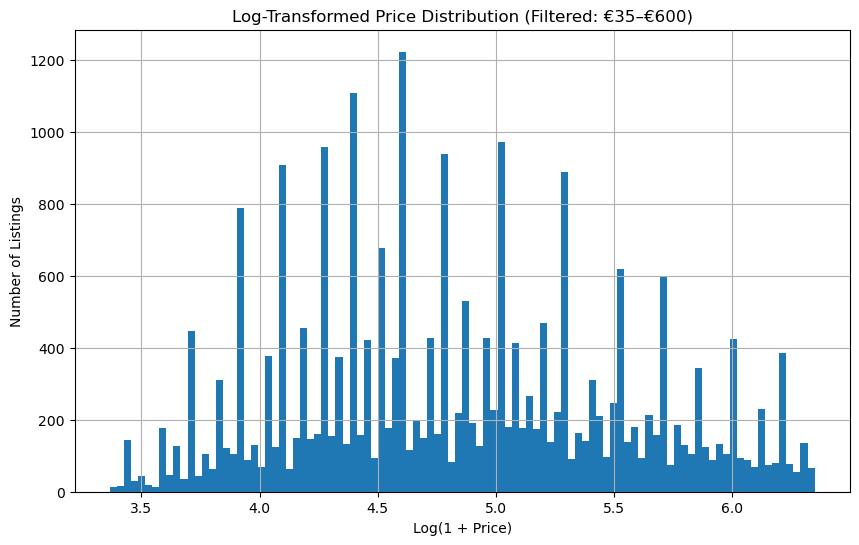

((25220, 232),
 ['has_reviews', 'accommodates', 'price', 'minimum_nights', 'maximum_nights'])

In [24]:
# STEP 1: Clean up the amenities column from string to list
sa_q1_df['amenities'] = sa_q1_df['amenities'].astype(str).str.strip("{}").str.replace('"', '')
sa_q1_df['amenities'] = sa_q1_df['amenities'].str.split(',')

# STEP 2: Trim spaces around amenities
sa_q1_df['amenities'] = sa_q1_df['amenities'].apply(lambda x: [i.strip() for i in x])

# STEP 3: Flatten all amenities into one list for frequency counting
all_amenities = sa_q1_df['amenities'].explode()

# STEP 4: Get top 40 most frequent amenities
top_amenities = all_amenities.value_counts().head(40).index

# STEP 5: Create binary columns for each top amenity
for amenity in top_amenities:
    safe_col = re.sub(r'\W+', '_', amenity).lower()
    sa_q1_df[f'amenity_{safe_col}'] = sa_q1_df['amenities'].apply(lambda x: int(amenity in x))

sa_q1_df.shape, sa_q1_df.filter(like='amenity_').columns

# Clean price column
sa_q1_df['price'] = sa_q1_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Impute missing values for key numerical columns
num_cols_to_impute = ['bathrooms', 'bedrooms', 'beds']
num_imputer = SimpleImputer(strategy='median')
sa_q1_df[num_cols_to_impute] = num_imputer.fit_transform(sa_q1_df[num_cols_to_impute])

# Handle review score columns
review_cols = [col for col in sa_q1_df.columns if col.startswith("review_scores_")]
sa_q1_df[review_cols] = sa_q1_df[review_cols].fillna(sa_q1_df[review_cols].median())

# Drop fully null or irrelevant columns
cols_to_drop = ['neighbourhood_group_cleansed', 'calendar_updated', 'host_neighbourhood']
sa_q1_df.drop(columns=[col for col in cols_to_drop if col in sa_q1_df.columns], inplace=True)

# One-hot encode key categoricals
categorical_features = ['room_type', 'property_type', 'neighbourhood_cleansed']
sa_q1_df = pd.get_dummies(sa_q1_df, columns=[col for col in categorical_features if col in sa_q1_df.columns], drop_first=True)

# Output final shape and sample of cleaned columns
sa_q1_df.shape, sa_q1_df.columns[:10]

# Identify relevant numeric columns for prediction
exclude_keywords = ['id', 'latitude', 'longitude', 'listing_url', 'host_id', 'scrape_id']
numeric_cols = sa_q1_df.select_dtypes(include=[np.number]).columns
relevant_numeric_cols = [col for col in numeric_cols if not any(key in col for key in exclude_keywords)]

# Create log-transformed versions for positively-valued columns only
for col in relevant_numeric_cols:
    if (sa_q1_df[col] > 0).all():
        sa_q1_df[f'log_{col}'] = np.log(sa_q1_df[col])

# Show how many log columns were created and preview a few
log_cols = [col for col in sa_q1_df.columns if col.startswith('log_')]
len(log_cols), log_cols[:10]

# Generate descriptive statistics for the 'price' column
price_description = sa_q1_df['price'].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
price_description

# Filter listings with price between 35 and 600 EUR
sa_q1_df = sa_q1_df[(sa_q1_df['price'] >= 28) & (sa_q1_df['price'] <= 570)]

# Recalculate log_price after filtering
sa_q1_df['log_price'] = np.log1p(sa_q1_df['price'])

# Plot histogram of the cleaned, log-transformed price
plt.figure(figsize=(10, 6))
sa_q1_df['log_price'].dropna().hist(bins=100)
plt.title("Log-Transformed Price Distribution (Filtered: €35–€600)")
plt.xlabel("Log(1 + Price)")
plt.ylabel("Number of Listings")
plt.grid(True)
plt.show()

# STEP 1: Extreme Values Handling
clip_cols = ['price', 'minimum_nights', 'maximum_nights', 'accommodates']
clip_thresholds = sa_q1_df[clip_cols].quantile(0.99)
for col in clip_cols:
    sa_q1_df[col] = np.clip(sa_q1_df[col], None, clip_thresholds[col])

# STEP 2: Create flag for listings with reviews
sa_q1_df['has_reviews'] = sa_q1_df['review_scores_rating'].notnull().astype(int)

sa_q1_df[review_cols] = sa_q1_df[review_cols].fillna(0)

# STEP 7: Drop high-cardinality or redundant columns
high_card_cols = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
    'description', 'neighborhood_overview', 'picture_url', 'host_id',
    'host_url', 'host_name', 'host_thumbnail_url', 'host_picture_url',
    'calendar_last_scraped', 'first_review', 'last_review', 'license'
]
sa_q1_df.drop(columns=[col for col in high_card_cols if col in sa_q1_df.columns], inplace=True)

sa_q1_df.shape, ['has_reviews'] + [col for col in sa_q1_df.columns if col in clip_cols]


In [25]:
# Align features to training set
X_sa = sa_q1_df.drop(columns=['price', 'amenities', 'log_price'], errors='ignore')
X_sa = X_sa.select_dtypes(include=[np.number])
X_sa = X_sa.reindex(columns=X_train.columns, fill_value=0)

# Impute missing values
X_sa_imputed = pd.DataFrame(imputer.transform(X_sa), columns=X_sa.columns)
y_sa = sa_q1_df['log_price']

# Evaluate on all 5 models
def evaluate_model(name, model, X, y):
    preds = model.predict(X)
    r2 = r2_score(y, preds)
    rmse = sqrt(mean_squared_error(y, preds))
    print(f"{name} → R²: {r2:.4f}, RMSE: {rmse:.4f}")
    return {'Model': name, 'R²': r2, 'RMSE': rmse}

results_sa = []
results_sa.append(evaluate_model("OLS", model_ols, X_sa_imputed, y_sa))
results_sa.append(evaluate_model("LASSO", lasso_model, X_sa_imputed, y_sa))
results_sa.append(evaluate_model("Random Forest", rf_model, X_sa_imputed, y_sa))
results_sa.append(evaluate_model("XGBoost", xgb_model, X_sa_imputed, y_sa))
results_sa.append(evaluate_model("LightGBM", lgb_model, X_sa_imputed, y_sa))

df_results_sa = pd.DataFrame(results_sa)
df_results_sa


OLS → R²: -11.1517, RMSE: 2.4047
LASSO → R²: -520.3572, RMSE: 15.7509
Random Forest → R²: 0.1592, RMSE: 0.6325
XGBoost → R²: 0.2164, RMSE: 0.6106
LightGBM → R²: 0.1703, RMSE: 0.6284


C:\Users\mailb\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(


,Model,R²,RMSE
0,OLS,-11.151714,2.404671
1,LASSO,-520.357151,15.750868
2,Random Forest,0.159173,0.632543
3,XGBoost,0.216404,0.610637
4,LightGBM,0.170276,0.628353



### Interpretation

The models performed notably worse on South Aegean Q1 than they did on either of the Crete datasets — a sign of weaker geographic transferability despite being in the same georgaphic region. This is expected, as the South Aegean region includes a broader mix of islands with diverse rental markets, price expectations, and seasonal patterns.

- **Linear models (OLS and LASSO)** performed extremely poorly, with negative R² scores and inflated RMSE values. This confirms that linear assumptions and fixed global coefficients learned on Crete are not transferable to a more heterogeneous regional context.
- **LASSO failed catastrophically**, similar to its breakdown in the Q4 temporal test — highlighting its vulnerability in both temporal and geographic generalization.
- **Tree-based models** once again proved more resilient. Although performance dropped compared to within-region tests, models like LightGBM and XGBoost still provided positive R² values and reasonable RMSE scores.
- **LightGBM emerged as the best-performing model**, with the lowest RMSE and highest R² in this out-of-sample test.


### Conclusion

Model performance in the South Aegean test reveals that even the best-performing models from Crete require caution when deployed regionally. Price determinants likely vary across islands due to differences in tourism profiles, property stock, and booking seasonality. 

On the other hand, despite model performance in South Aegean is notably weaker than on Crete, the results from Random Forest, XGBoost, and LightGBM remain valid and meaningful. Achieving RMSE scores around 0.61–0.63 in a setting with substantial geographic and listing diversity is a strong indication of model robustness.

It’s important to acknowledge that the models were trained on data from a single island (Crete) and evaluated on a highly fragmented archipelago where many influential factors — such as ferry access and other access infrustructure, popularity among foreign tourists, microclimate, and island-specific features — are not captured in the available dataset. In light of these unmeasured variables, the tree-based models' ability to predict log prices within a narrow RMSE range suggests that they successfully extracted stable, transferable patterns from the available features (e.g., amenities, room type, host activity).

An RMSE of approximately 0.6 in log-price space translates to prediction errors in the 10–20% range in price terms, which is within the acceptable tolerance for many practical pricing strategies, especially in highly seasonal and geographically fragmented markets like the Aegean Sea.

One limitation worth noting is the possibility of overlapping listings across the datasets used in this analysis. Since data for Crete Q1, Crete Q4, and South Aegean Q1 were sourced from the same platform and time-based snapshots, there may be listings that appear in both training and testing datasets, particularly for long-standing hosts or permanent rental properties.

This overlap could partially inflate model performance, especially for listings with stable prices and characteristics across quarters. However, the sharp drop in model performance — particularly for the South Aegean test — suggests that the majority of generalization is occurring across distinct observations, not duplicates.

That said, an extension of this study can include listing-level identifiers to ensure a clear separation of training and testing data where possible. Despite this caveat, the current results remain valid and demonstrate clear patterns of model robustness and vulnerability under both temporal and geographic shifts.